In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv("train.csv")
train_df.head()



,Score,Text
0,5,I received this product early from the seller!...
1,5,*****<br />Numi's Collection Assortment Melang...
2,5,"I was very careful not to overcook this pasta,..."
3,5,Buying this multi-pack I was misled by the pic...
4,5,These bars are so good! I loved them warmed up...


In [3]:
train_df['Text'] = train_df['Text'].str.lower()
train_df.head()

,Score,Text
0,5,i received this product early from the seller!...
1,5,*****<br />numi's collection assortment melang...
2,5,"i was very careful not to overcook this pasta,..."
3,5,buying this multi-pack i was misled by the pic...
4,5,these bars are so good! i loved them warmed up...


In [4]:
import string
train_df['Text'] = train_df['Text'].str.translate(str.maketrans('', '', string.punctuation))
train_df.head()

,Score,Text
0,5,i received this product early from the seller ...
1,5,br numis collection assortment melange include...
2,5,i was very careful not to overcook this pasta ...
3,5,buying this multipack i was misled by the pict...
4,5,these bars are so good i loved them warmed up ...


In [5]:
train_df['Text'] = train_df['Text'].str.replace(r'\d+', '', regex=True)

In [6]:
import nltk
from nltk.corpus import stopwords
import contractions

nltk.download('stopwords')

def expand_and_remove_stopwords(text):
    expanded_text = contractions.fix(text)
    stop_words = set(stopwords.words('english'))
    words = expanded_text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

train_df['Text'] = train_df['Text'].apply(expand_and_remove_stopwords)
train_df.head()

[nltk_data] Downloading package stopwords to C:\Users\Athin
[nltk_data]     Suresh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Score,Text
0,5,received product early seller tastey great mid...
1,5,br numis collection assortment melange include...
2,5,careful overcook pasta making sure take bite e...
3,5,buying multipack misled picture whole hazel nu...
4,5,bars good loved warmed definitely think great ...


In [7]:
import nltk
from nltk.corpus import stopwords
import contractions
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize
train_df['TextTokens'] = train_df['Text'].apply(word_tokenize)

train_df.head()

[nltk_data] Downloading package punkt_tab to C:\Users\Athin
[nltk_data]     Suresh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,Score,Text,TextTokens
0,5,received product early seller tastey great mid...,"[received, product, early, seller, tastey, gre..."
1,5,br numis collection assortment melange include...,"[br, numis, collection, assortment, melange, i..."
2,5,careful overcook pasta making sure take bite e...,"[careful, overcook, pasta, making, sure, take,..."
3,5,buying multipack misled picture whole hazel nu...,"[buying, multipack, misled, picture, whole, ha..."
4,5,bars good loved warmed definitely think great ...,"[bars, good, loved, warmed, definitely, think,..."


In [8]:
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
train_df['TextTokens'] = train_df['TextTokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
train_df['TextTokens'] = train_df['TextTokens'].apply(lambda tokens: ' '.join(tokens))
train_df.head()

[nltk_data] Downloading package wordnet to C:\Users\Athin
[nltk_data]     Suresh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Score,Text,TextTokens
0,5,received product early seller tastey great mid...,received product early seller tastey great mid...
1,5,br numis collection assortment melange include...,br numis collection assortment melange include...
2,5,careful overcook pasta making sure take bite e...,careful overcook pasta making sure take bite e...
3,5,buying multipack misled picture whole hazel nu...,buying multipack misled picture whole hazel nu...
4,5,bars good loved warmed definitely think great ...,bar good loved warmed definitely think great s...


In [9]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM

In [10]:
VOCAB_SIZE = 10000  # Number of unique words to keep
SEQUENCE_LENGTH = 100  # Fixed length of input sequences

In [11]:
X_train = train_df['Text'].values
Y_train = train_df['Score'].values

In [12]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH  # Ensures uniform length
)

# Fit the TextVectorization layer to the text data
encoder.adapt(X_train)

In [13]:
vocab = np.array(encoder.get_vocabulary())
print(vocab[:20])  # Display the first 20 words

['' '[UNK]' 'br' 'like' 'good' 'taste' 'one' 'great' 'product' 'coffee'
 'flavor' 'would' 'tea' 'love' 'get' 'really' 'food' 'much' 'use' 'also']


In [14]:
# Sample text to test the encoder
sample_text = "This is a sample review."

# Use the encoder to transform the text into integers
encoded_text = encoder(tf.constant([sample_text]))

# Display the result
print(encoded_text.numpy())

[[  1   1   1 932 260   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]


In [15]:
X_train_vectorized = encoder(X_train)

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

# Ensure X_train_vectorized is a NumPy array
X_train_vectorized_np = X_train_vectorized.numpy() if isinstance(X_train_vectorized, tf.Tensor) else X_train_vectorized

# Split data into training and validation sets (80% training, 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_vectorized_np, Y_train, test_size=0.2, random_state=42
)


In [17]:
# Check the shape of X_train and X_val
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")

# Print the first few tokenized sequences from X_train
print(f"Sample of tokenized X_train (first 3 samples):\n{X_train[:3]}")

# Print the first few tokenized sequences from X_val
print(f"Sample of tokenized X_val (first 3 samples):\n{X_val[:3]}")


Shape of X_train: (247304, 100)
Shape of X_val: (61827, 100)
Sample of tokenized X_train (first 3 samples):
[[  69  125 1519 5645  260   59   21 1971  711 1484 6344   44 2409  320
   260 1110  104  425  247  412 3674 6046 6226  276 1605 1375   86  256
  1038 2474    1  406   14 7158  700  214   30 2359   44  823   99 1588
   158 2409    1  843  135  667   99  118 1303    1    2  237   13 5547
  5570  107 5547  215   14  128 1751  259   44  871  187  119 4204  855
   844    3  818  172    1  256 2047  104  855  471 3328  320  228  127
    47  590 2266  141  243   18  349  237  226  275   62  256    1    6
   352  473]
 [  46  270 1196   37   32 1473   83   13   98   18   25    7  193  585
   120  123    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,), dtype=tf.int32),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=32, mask_zero=True), #Reduced embedding size.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)), #reduced LSTM units
    tf.keras.layers.Dropout(0.5), #dropout after first LSTM.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), #reduced LSTM units
    tf.keras.layers.Dropout(0.5), #dropout after second LSTM.
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), #reduced dense units, and L2 regularization.
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 32)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 100, 64)             │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 363,717 (1.39 MB)

 Trainable params: 363,717 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [22]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
Y_train_fixed = np.array(Y_train) - 1  # Shift labels from [1-5] to [0-4]
Y_val_fixed = np.array(Y_val) - 1  # Shift validation labels similarly

# Convert to one-hot encoding
Y_train_one_hot = to_categorical(Y_train_fixed, num_classes=5)
Y_val_one_hot = to_categorical(Y_val_fixed, num_classes=5)


# Now fit the model with one-hot encoded labels
history = model.fit(
    X_train, Y_train_one_hot,  # Use one-hot encoded labels
    validation_data=(X_val, Y_val_one_hot),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 548s 68ms/step - accuracy: 0.6762 - loss: 0.9398 - val_accuracy: 0.7156 - val_loss: 0.7713
Epoch 2/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 514s 66ms/step - accuracy: 0.7123 - loss: 0.7822 - val_accuracy: 0.7235 - val_loss: 0.7600
Epoch 3/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 519s 67ms/step - accuracy: 0.7258 - loss: 0.7408 - val_accuracy: 0.7252 - val_loss: 0.7553
Epoch 4/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 520s 67ms/step - accuracy: 0.7347 - loss: 0.7139 - val_accuracy: 0.7242 - val_loss: 0.7575
Epoch 5/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 520s 67ms/step - accuracy: 0.7456 - loss: 0.6865 - val_accuracy: 0.7253 - val_loss: 0.7684
Epoch 6/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 520s 67ms/step - accuracy: 0.7536 - loss: 0.6647 - val_accuracy: 0.7198 - val_loss: 0.7907
Epoch 7/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 525s 68ms/step - accuracy: 0.7627 - loss: 0.6370 - val_accuracy: 0.7184 - val_loss: 0.8008
Epoch 8/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 521s 67ms/step - accuracy: 

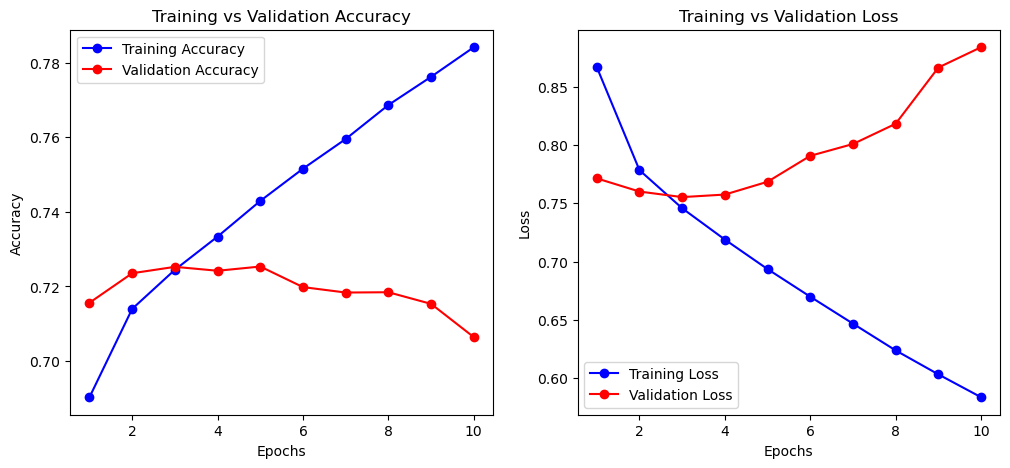

In [23]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label="Training Loss")
plt.plot(epochs, val_loss, 'ro-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


In [24]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,), dtype=tf.int32),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=32, mask_zero=True), #Reduced embedding size.
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True)), #reduced LSTM units
    tf.keras.layers.Dropout(0.5), #dropout after first LSTM.
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)), #reduced LSTM units
    tf.keras.layers.Dropout(0.5), #dropout after second LSTM.
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), #reduced dense units, and L2 regularization.
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model_gru.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 32)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 100, 64)             │          12,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 64)                  │          18,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 353,733 (1.35 MB)

 Trainable params: 353,733 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [26]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
Y_train_fixed = np.array(Y_train) - 1  # Shift labels from [1-5] to [0-4]
Y_val_fixed = np.array(Y_val) - 1  # Shift validation labels similarly

# Convert to one-hot encoding
Y_train_one_hot = to_categorical(Y_train_fixed, num_classes=5)
Y_val_one_hot = to_categorical(Y_val_fixed, num_classes=5)


# Now fit the model with one-hot encoded labels
history = model_gru.fit(
    X_train, Y_train_one_hot,  # Use one-hot encoded labels
    validation_data=(X_val, Y_val_one_hot),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 916s 114ms/step - accuracy: 0.6741 - loss: 0.9464 - val_accuracy: 0.7216 - val_loss: 0.7591
Epoch 2/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 895s 116ms/step - accuracy: 0.7176 - loss: 0.7676 - val_accuracy: 0.7247 - val_loss: 0.7471
Epoch 3/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 907s 117ms/step - accuracy: 0.7290 - loss: 0.7293 - val_accuracy: 0.7269 - val_loss: 0.7477
Epoch 4/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 539s 70ms/step - accuracy: 0.7377 - loss: 0.7047 - val_accuracy: 0.7252 - val_loss: 0.7502
Epoch 5/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 522s 68ms/step - accuracy: 0.7479 - loss: 0.6779 - val_accuracy: 0.7231 - val_loss: 0.7774
Epoch 6/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 524s 68ms/step - accuracy: 0.7557 - loss: 0.6542 - val_accuracy: 0.7166 - val_loss: 0.7872
Epoch 7/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 527s 68ms/step - accuracy: 0.7656 - loss: 0.6317 - val_accuracy: 0.7168 - val_loss: 0.8082
Epoch 8/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 528s 68ms/step - accurac

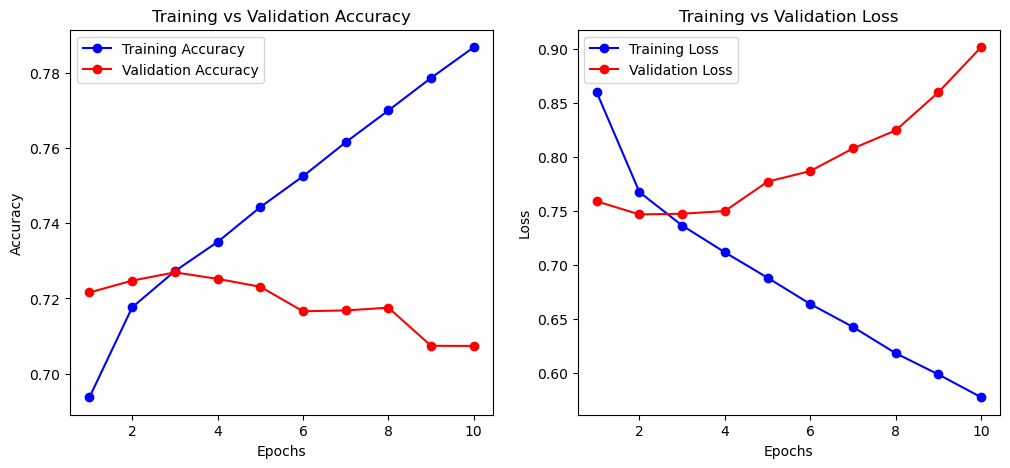

In [27]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label="Training Loss")
plt.plot(epochs, val_loss, 'ro-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()
